In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

In [3]:
using CairoMakie # Plots related stuff
using BenchmarkTools, DataFrames, Query # Analysis tools
import ReactiveMP, Turing, Rocket, GraphPPL, Distributions, LinearAlgebra, Random # Bayesian Inference packages

ENV["COLUMNS"] = 2000 # For DataFrames

2000

In [4]:
# See 'fl_gaussian_linear_state_space_model.ipynb' notebook
fl_c_n    = [ 50, 100, 200, 250, 300, 50, 100, 200, 250, 300 ]
fl_c_d    = [ 2, 2, 2, 2, 2, 4, 4, 4, 4, 4 ]
fl_c_time = 1e9 .* [ 22.726305 + 15.300824, 47.139422 + 65.614497, 86.241535 + 288.590772, 117.509299 + 557.830418, 137.006022 + 920.685297, 23.327590 + 17.412056, 46.829628 + 65.860935, 88.016589 + 318.073160, 119.371944 + 569.752148, 136.036903 + 868.833146 ]

fl_i_n    = [ 50, 100, 200, 250, 300, 50, 100, 200, 250, 300 ]
fl_i_d    = [ 2, 2, 2, 2, 2, 4, 4, 4, 4, 4 ]
fl_i_time = 1e6 .* [ 1.765, 4.036, 6.128, 10.248, 11.570, 2.302, 3.579, 7.681, 12.099, 12.685 ]

fl_compilation = DataFrame(n = fl_c_n, d = fl_c_d, time = fl_c_time)
fl_inference   = DataFrame(n = fl_i_n, d = fl_i_d, time = fl_i_time);

In [5]:
white_list   = [ "n", "d" ]
special_list = [
    :time => (data) -> minimum(data["benchmark"]).time,
]

rmp_smoothing = collect_results(datadir("benchmark", "lgssm", "smoothing"), white_list = white_list, special_list = special_list, verbose = false);
turing_hmc    = collect_results(datadir("benchmark", "lgssm", "turing"), white_list = [ white_list..., "nsamples" ], special_list = special_list, verbose = false);

┌ Info: Scanning folder /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/lgssm/smoothing for result files.
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/rnbAO/src/result_collection.jl:107
┌ Info: Scanning folder /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/lgssm/turing for result files.
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/rnbAO/src/result_collection.jl:107


In [6]:
function extract_line(results, d_)
    t = sort(collect(map(r -> (r["n"], r["time"]), eachrow(filter((d) -> d["d"] == d_, results)))), by=first)
    return first.(t), map(e -> e / 1e6, last.(t)) # cast to ms
end

function extract_line_turing(results, d_, nsamples_)
    t = sort(collect(map(r -> (r["n"], r["time"]), eachrow(filter((d) -> d["d"] == d_ && d["nsamples"] == nsamples_, results)))), by=first)
    return first.(t), map(e -> e / 1e6, last.(t)) # cast to ms
end

extract_line_turing (generic function with 1 method)

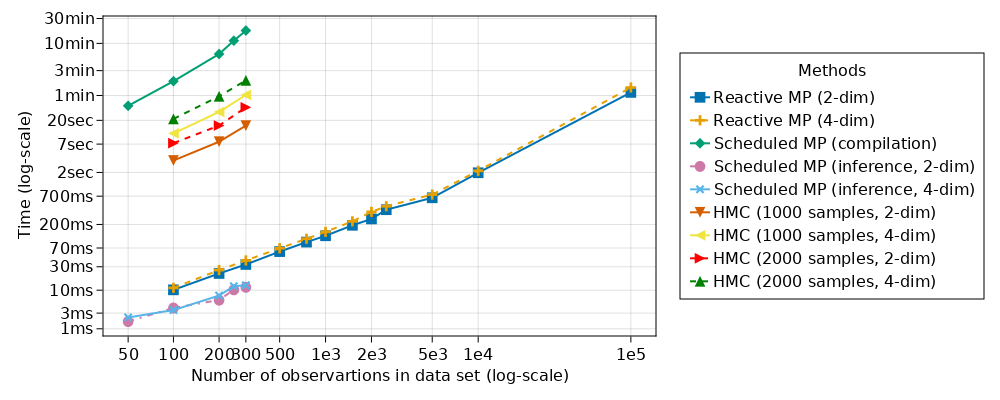

In [7]:
let 
    fig = Figure(resolution = (1000, 400))

    ax = Makie.Axis(fig[1, 1])

    ax.xlabel = "Number of observartions in data set (log-scale)"
    ax.xlabelsize = 16
    ax.ylabel = "Time (log-scale)"
    ax.ylabelsize = 16
    ax.yscale = Makie.pseudolog10
    ax.xscale = Makie.pseudolog10
    
    colors = CairoMakie.Makie.wong_colors()

    ax.yticks = (
        [ 1, 3, 10, 30, 70, 200, 700, 2000, 7000, 20_000, 60_000, 180_000, 600_000, 1_800_000, ], 
        [ "1ms", "3ms", "10ms", "30ms", "70ms", "200ms", "700ms", "2sec", "7sec", "20sec", "1min", "3min", "10min", "30min" ]
    )

    ax.xticks = (
        [ 50, 100, 200, 300, 500, 1000, 2000, 5000, 10000, 100_000 ], 
        [ "50", "100", "200", "300", "500", "1e3", "2e3", "5e3", "1e4", "1e5" ]
    )
    
    rmp_smoothing_2_x, rmp_smoothing_2_y = extract_line(rmp_smoothing, 2)
    rmp_smoothing_4_x, rmp_smoothing_4_y = extract_line(rmp_smoothing, 4)
    
    fl_compilation_x, fl_compilation_y = extract_line(fl_compilation, 2)
    fl_inference_2_x, fl_inference_2_y = extract_line(fl_inference, 2)
    fl_inference_4_x, fl_inference_4_y = extract_line(fl_inference, 4)
    
    turing_1000_2_x, turing_1000_2_y = extract_line_turing(turing_hmc, 2, 1000)
    turing_1000_4_x, turing_1000_4_y = extract_line_turing(turing_hmc, 4, 1000)
    
    turing_2000_2_x, turing_2000_2_y = extract_line_turing(turing_hmc, 2, 2000)
    turing_2000_4_x, turing_2000_4_y = extract_line_turing(turing_hmc, 4, 2000)

    scatterlines!(ax, rmp_smoothing_2_x, rmp_smoothing_2_y, label = "Reactive MP (2-dim)", linewidth = 2, marker = :rect, markersize = 14, color = colors[1], markercolor = colors[1])
    scatterlines!(ax, rmp_smoothing_4_x, rmp_smoothing_4_y, label = "Reactive MP (4-dim)", linewidth = 2, linestyle = :dash, marker = :cross, markersize = 14, color = colors[2], markercolor = colors[2])
    
    scatterlines!(ax, fl_compilation_x, fl_compilation_y, label = "Scheduled MP (compilation)", linewidth = 2, linestyle = nothing, marker = :diamond, markersize = 14, color = colors[3], markercolor = colors[3])
    scatterlines!(ax, fl_inference_2_x, fl_inference_2_y, label = "Scheduled MP (inference, 2-dim)", linewidth = 2, linestyle = :dashdot, marker = :circle, markersize = 14, color = colors[4], markercolor = colors[4])
    scatterlines!(ax, fl_inference_4_x, fl_inference_4_y, label = "Scheduled MP (inference, 4-dim)", linewidth = 2, linestyle = nothing, marker = :xcross, markersize = 14, color = colors[5], markercolor = colors[5])
    
    scatterlines!(ax, turing_1000_2_x, turing_1000_2_y, label = "HMC (1000 samples, 2-dim)", linewidth = 2, marker = :dtriangle, markersize = 14, color = colors[6], markercolor = colors[6])
    scatterlines!(ax, turing_1000_4_x, turing_1000_4_y, label = "HMC (1000 samples, 4-dim)", linewidth = 2, marker = :ltriangle, markersize = 14, color = colors[7], markercolor = colors[7])
    
    scatterlines!(ax, turing_2000_2_x, turing_2000_2_y, label = "HMC (2000 samples, 2-dim)", linewidth = 2, linestyle = :dash, marker = :rtriangle, markersize = 14, color = :red, markercolor = :red)
    scatterlines!(ax, turing_2000_4_x, turing_2000_4_y, label = "HMC (2000 samples, 4-dim)", linewidth = 2, linestyle = :dash, marker = :utriangle, markersize = 14, color = :green, markercolor = :green)
    

    # axislegend(ax, position = :rb, labelsize = 16)
    fig[1, 2] = Legend(fig, ax, "Methods", framevisible = true, labelsize = 16)
    
    @saveplot fig "lgssm_benchmark_all"
end